This Notebook builds a model that uses properties found by proteins grouping. Each datapoint of the train set consists of the comparision between the wildtype and a mutated protein. We use Blosum matrix to have the distance between the two aminoacids that change, the difference in pH. The difference in temperature is used as label. Then, those results are combined with a CNN that allows to train on the protein's sequence.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter
from helpers import *

In [2]:
#Import the blosum matrix
import blosum as bl
matrix = bl.BLOSUM(62)

1. Load the dataset 

In [3]:
#load training data (will be put in a function later) 

path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'clean_train_data.csv')

#Drop the features that don't interest us
train_df = train_df.drop(columns=['data_source1'])
train_df = train_df.drop(columns=['data_source2'])

train_df = train_df.drop(columns=['protSeq2'])
train_df = train_df.drop(columns=['tm1'])
train_df = train_df.drop(columns=['tm2'])
train_df = train_df.drop(columns=['group1'])
train_df = train_df.drop(columns=['group2'])

train_df = train_df.dropna()

train_df.head()
#dT = 'target'

,protSeq1,operation,position1,position2,change1,change2,pH1,pH2,target
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,D,6.5,6.5,-6.7
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,E,6.5,6.5,-3.9
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,F,6.5,6.5,-1.2
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,G,6.5,6.5,-4.0
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,L,6.5,6.5,2.7


In [4]:
test_df = pd.read_csv(path+ 'test_mutations.csv', index_col="seq_id")
test_df = test_df.drop(columns=['data_source'])
test_df = test_df.drop(columns=['b_factor'])
test_df = test_df.drop(columns=['bFactorAdj'])
test_df = test_df.drop(columns=['score'])
test_df = test_df.drop(columns=['position1'])
test_df = test_df.drop(columns=['position2'])

test_df = test_df[test_df['pH']==8]



Prepare the data

In [5]:
test_df['length'] = test_df['protein_sequence'].str.len()


In [6]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protSeq1'].str.len()
train_df['protein_sequence'] = train_df['protSeq1']
train_df = train_df.drop(columns=['protSeq1'])



In [7]:
#Put the distance of the 2 aa as a feature, with blosum: 
#hypothesis : this score influences the delta Tm. 
#Allows to encode the "mutation" and the info : which aa into which aa

def blosum_apply(row):
        if (row['operation']=='replace'):
            res = matrix[row['change1'] + row['change2']]
        else:
                res = -10
        return res

train_df['dist_mutation'] = train_df.apply(blosum_apply, axis=1)
test_df['dist_mutation'] = test_df.apply(blosum_apply, axis=1)

In [8]:
test_df = test_df.drop(columns=['change1'])
test_df = test_df.drop(columns=['change2'])


In [9]:
train_df = train_df.drop(columns=['change1'])
train_df = train_df.drop(columns=['change2'])

In [10]:
#Compute the relative position of the mutation, compared to the total length

train_df['relative_position'] = train_df['position1']/train_df['length']
train_df = train_df.drop(columns=['position1'])
train_df = train_df.drop(columns=['position2'])


In [11]:
test_df['relative_position'] = test_df['modif']/test_df['length']
test_df = test_df.drop(columns=['modif'])

In [12]:
train_df.head()

,operation,pH1,pH2,target,length,protein_sequence,dist_mutation,relative_position
0,replace,6.5,6.5,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195
1,replace,6.5,6.5,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195
2,replace,6.5,6.5,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195
3,replace,6.5,6.5,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195
4,replace,6.5,6.5,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195


In [13]:
test_df.head()


,protein_sequence,pH,score_adj,operation,length,dist_mutation,relative_position
seq_id,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.880797,replace,221,-3.0,0.072398
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.880797,replace,221,-2.0,0.072398
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,0.999955,delete,220,-10.0,0.072727
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.952574,replace,221,-3.0,0.076923
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.952574,replace,221,-3.0,0.076923


In [14]:
#Compute difference of pH
train_df['dPH'] = train_df['pH1']-train_df['pH2']
train_df = train_df.drop(columns=['pH1'])
train_df = train_df.drop(columns=['pH2'])

In [15]:
train_df.head()

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH
0,replace,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
1,replace,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0
2,replace,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
3,replace,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195,0.0
4,replace,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0


In [16]:
test_df['dPH'] =test_df['pH'] - 8
test_df = test_df.drop(columns=['pH'])

In [17]:
test_df = test_df.drop(columns=['score_adj'])

In [18]:
test_df = test_df.drop(columns=['operation'])
trian_df = train_df.drop(columns=['operation'])

In [19]:
#Final data: 

In [20]:
test_df.head()

,protein_sequence,length,dist_mutation,relative_position,dPH
seq_id,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.072398,0
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-2.0,0.072398,0
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,220,-10.0,0.072727,0
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.076923,0
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.076923,0


In [21]:
train_df.head()

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH
0,replace,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
1,replace,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0
2,replace,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
3,replace,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195,0.0
4,replace,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0


In [22]:
#Max length is the maximal length of train data here

max_length = np.max(train_df['length'])


In [23]:
# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))

In [24]:
train_df

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH,encoded_sequence
0,replace,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,replace,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,replace,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,replace,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195,0.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,replace,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
2291,replace,12.6,537,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,-2.0,0.160149,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2292,replace,25.9,537,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,-2.0,0.160149,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2293,replace,-7.6,537,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,0.0,0.160149,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2294,replace,-13.3,537,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,1.0,0.160149,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [25]:
df = train_df.copy()

In [26]:
df = df.reset_index(drop=True)


In [27]:
test_df = test_df.reset_index(drop=True)

Split to train and validation sets

In [28]:
train_df , val_df = split_train_test(df,frac=0.8)

train_df has shape : (1837, 8) 
 test_df has shape :  (459, 8)


2. The Dataset and the model

In [29]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
        sequence= df['encoded_sequence']
        
        # numerical : pH and length
        numerical = df[['dPH','length', 'relative_position', 'dist_mutation']].values

        # y : the target (tm)
        if train == True : 
            y=df['target'].values
        else : 
            y = np.zeros(np.shape(numerical)[0])
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx], self.y[idx],self.num[idx]


In [30]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 200


In [31]:
# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_1409353/2109705618.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.x_sequence=torch.tensor(sequence)


In [32]:
class CNN_Grouping(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            
            nn.Conv1d(20, 10,kernel_size=6, stride=1, padding=3),
            nn.ELU(),
            

            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            
         
            torch.nn.MaxPool1d(10), 
            
            torch.nn.Flatten(),
            torch.nn.Dropout2d(p=0.5, inplace=False),
            
 
            

        )
        self.numerical = nn.Sequential(
            nn.Linear(4, 20),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(20, 100),
            nn.ELU(),
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Linear(100, 4),
            
            
        )
        self.mlp = nn.Sequential(
            nn.Linear(524, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ELU(),
 
            nn.Linear(128, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 1),
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

In [33]:
model = CNN_Grouping()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


3. K Fold

In [34]:
from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


In [35]:
#train model and preditct
train_rho_history = []
train_loss_history = []
test_rho_history = []
test_loss_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    test_loss, rho_test = test_epoch(
        model, criterion, val_dl
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)



/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Average loss: 7.54e+01 
Test set: Average loss: 7.48e+01 
Test set: Average loss: 7.13e+01 
Test set: Average loss: 7.01e+01 
Test set: Average loss: 7.58e+01 
Test set: Average loss: 7.11e+01 
Test set: Average loss: 7.34e+01 
Test set: Average loss: 7.04e+01 
Test set: Average loss: 7.09e+01 
Test set: Average loss: 7.89e+01 
Test set: Average loss: 7.42e+01 
Test set: Average loss: 7.37e+01 
Test set: Average loss: 7.11e+01 
Test set: Average loss: 7.28e+01 
Test set: Average loss: 7.60e+01 
Test set: Average loss: 7.28e+01 
Test set: Average loss: 7.41e+01 
Test set: Average loss: 7.39e+01 
Test set: Average loss: 7.04e+01 
Test set: Average loss: 7.73e+01 
Test set: Average loss: 8.00e+01 
Test set: Average loss: 7.26e+01 
Test set: Average loss: 7.07e+01 
Test set: Average loss: 7.13e+01 
Test set: Average loss: 6.21e+01 
Test set: Average loss: 6.90e+01 
Test set: Average loss: 6.40e+01 
Test set: Average loss: 6.15e+01 
Test set: Average loss: 5.86e+01 
Test set: Aver

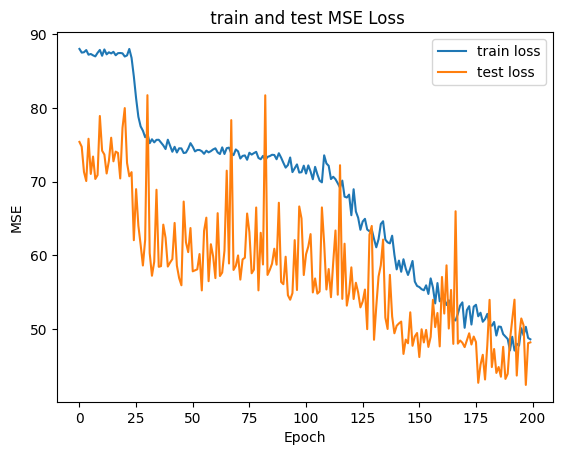

In [36]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('mutations_and_seq_loss.png')


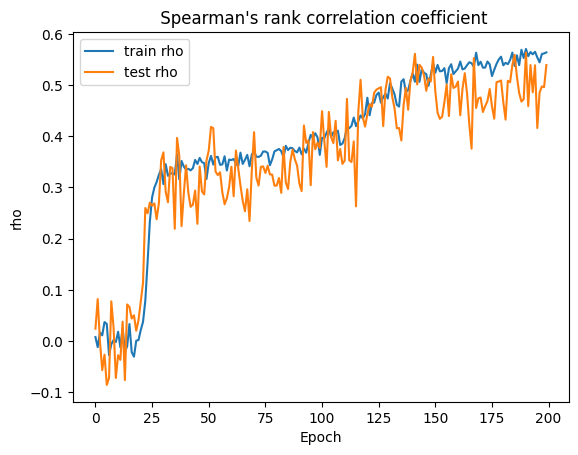

In [37]:
#Spearman's rank correlation coefficient
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('mutations_and_seq_rho.png')

In [38]:
#Kaggle submission

In [39]:
#Prediction for Kaggle's submission
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders
sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)

/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [40]:
sub = pd.read_csv(path+ 'test.csv',index_col='seq_id')
sub['tm']=submission_df
sub = sub.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('Effect_mutation_seq.csv', index=True)